In [113]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import fastcluster
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import math
from sklearn.decomposition import PCA

# tushare读数据
import tushare as ts
ts.set_token('a058cd003f0dc76413ae9a5fb22134153fc3d72d0ea2b4d37dd239c9')
pro = ts.pro_api()
tickers = ['600000.SH', '600009.SH', '600016.SH', '600028.SH', '600030.SH', '600031.SH', '600036.SH', '600048.SH', '600050.SH', '600104.SH', '600196.SH', '600276.SH', '600309.SH', '600438.SH', '600519.SH', '600547.SH', '600570.SH', '600585.SH', '600588.SH', '600690.SH', '600703.SH', '600745.SH', '600809.SH', '600837.SH', '600887.SH', '600893.SH', '600918.SH', '601012.SH', '601066.SH', '601088.SH', '601138.SH', '601166.SH', '601211.SH', '601288.SH', '601318.SH', '601336.SH', '601398.SH', '601601.SH', '601628.SH', '601668.SH', '601688.SH', '601818.SH', '601857.SH', '601888.SH', '601899.SH', '601995.SH', '603259.SH', '603288.SH', '603501.SH', '603986.SH']
def get_returns(start, end):
    stocks = pro.daily(ts_code=tickers[0], start_date=start, end_date=end, fields=['trade_date'])
    for ticker in tickers:
        stock = pro.daily(ts_code=ticker, start_date=start, end_date=end, fields=['trade_date', 'close'])
        stock = stock.rename(columns={"close" : ticker})
        stocks = stocks.merge(stock,on=['trade_date'])
    stocks.set_index(['trade_date'], inplace=True)
    stocks = stocks.iloc[::-1]
    stocks = stocks.dropna()
    # returns = stocks.pct_change().iloc[1:] # (pre_close - close)/pre_close
    return stocks

# 函数correlations 输入标准化的returns, nb_clusters 返回sorted_correlations, HPCA_corr
def correlations(returns, nb_clusters):
    ### 分层聚类--使得相关系数大的股票离得更近
    corr = returns.corr(method='pearson')   #股票returns的相关系数
    dist = 1 - corr.values
    tri_a, tri_b = np.triu_indices(len(dist), k=1)
    linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward') # 最短最长平均法做层次聚类
    permutation = hierarchy.leaves_list(hierarchy.optimal_leaf_ordering(linkage, dist[tri_a, tri_b])) # 重新排序切割树 得到叶节点
    sorted_stocks = returns.columns[permutation]
    sorted_corrs = corr.values[permutation, :][:, permutation]
    sorted_correlations = pd.DataFrame(sorted_corrs, index=sorted_stocks, columns=sorted_stocks) # 层次聚类排序后的股票相关系数 靠近斜对角线的系数更大，对应股票相关性更强 

    ### 根据sorted_correlations将股票分成若干簇  注意！如果没有明显的资产分组，HPCA会加强一个虚假的结构
    dist = 1 - sorted_correlations.values
    dim = len(dist)
    tri_a, tri_b = np.triu_indices(dim, k=1)
    linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
    clustering_inds = hierarchy.fcluster(linkage, nb_clusters,
                                        criterion='maxclust')
    clusters = {i: [] for i in range(min(clustering_inds),
                                    max(clustering_inds) + 1)}
    for i, v in enumerate(clustering_inds):
        clusters[v].append(i)

    permutation = sorted([(min(elems), c) for c, elems in clusters.items()],
                        key=lambda x: x[0], reverse=False)
    sorted_clusters = {}
    for cluster in clusters:
        sorted_clusters[cluster] = clusters[permutation[cluster - 1][1]]
    # 画每簇的成员股票累计收益率 簇内股票收益率相关性强 累计收益率曲线相似 注意！若相关系数不大，曲线不相似，可以增大簇的个数
    stock_to_cluster = {}
    for cluster in sorted_clusters:
        cluster_members = sorted_correlations.columns[sorted_clusters[cluster]].tolist()
        for stock in cluster_members:
            stock_to_cluster[stock] = cluster
    ### 簇内股票收益率矩阵 右乘 簇内相关系数矩阵的第一特征向量 除以 最大特征值的平方 得收益率降维后的值
    eigen_clusters = {}
    for cluster in clusters:
        cluster_members = sorted_correlations.columns[
            sorted_clusters[cluster]].tolist()
        corr_cluster = sorted_correlations.loc[
            cluster_members, cluster_members]
        cluster_returns = returns[cluster_members]
        eigenvals, eigenvecs = np.linalg.eig(corr_cluster.values) # 簇内相关系数的特征值、特征向量
        idx = eigenvals.argsort()[::-1]
        eigenvals, eigenvecs = eigenvals[idx], eigenvecs[:, idx]
        val1, vec1= eigenvals[0], eigenvecs[:, 0] # 簇内相关系数的最大特征值、第一特征向量
        F1 = (1 / np.sqrt(val1)) * np.dot(cluster_returns.values,vec1) # 得簇内收益率降维后的值 392*10 × 10*1 = 392*1  将股票收益率整合到方差最大的线性方向上
        eigen_clusters[cluster] = F1
    # 股票收益率和对应簇内降维收益率的线性回归斜率
    betas = {}
    for stock in returns.columns:
        stock_returns = returns[stock]
        cluster_F1 = eigen_clusters[stock_to_cluster[stock]]
        reg = LinearRegression(fit_intercept=False).fit(
            cluster_F1.reshape(-1, 1), stock_returns)
        beta = reg.coef_[0]
        betas[stock] = beta 
    ### 更新不同簇的股票之间的相关系数 体现出簇间相关性
    HPCA_corr = sorted_correlations.copy()
    for stock_1 in HPCA_corr.columns:
        beta_1 = betas[stock_1]
        F1_1 = eigen_clusters[stock_to_cluster[stock_1]]
        for stock_2 in HPCA_corr.columns:
            beta_2 = betas[stock_2]
            F1_2 = eigen_clusters[stock_to_cluster[stock_2]]
            if stock_to_cluster[stock_1] != stock_to_cluster[stock_2]: # 对不同簇股票的相关系数调整 体现簇间差异
                rho_sector = np.corrcoef(F1_1, F1_2)[0, 1] # 簇间相关性
                mod_rho = beta_1 * beta_2 * rho_sector
                HPCA_corr.at[stock_1, stock_2] = mod_rho
    return sorted_correlations, HPCA_corr

# KMO测度函数 输入相关系数矩阵 返回kmo_value测度值
def kmo(dataset_corr):
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    A = np.ones((nrow_inv_corr, ncol_inv_corr))
    for i in range(0, nrow_inv_corr, 1):
        for j in range(i, ncol_inv_corr, 1):
            A[i, j] = -(corr_inv[i, j]) / (math.sqrt(corr_inv[i, i] * corr_inv[j, j]))
            A[j, i] = A[i, j]
    dataset_corr = np.asarray(dataset_corr)
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(A)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    return kmo_value

In [115]:
start = '20201102'
end = '20230320'
stock_returns = get_returns(start, end)
stock_returns.to_csv('stock.csv')

In [61]:
start = '20201102'
end = '20230320'
stock_returns = get_returns(start, end)
stock_returns.index = stock_returns.index.astype('int64')

etf_returns = pd.read_csv('510050.csv')
etf_returns.set_index(['trade_date'],inplace=True)

fut_returns = pd.read_csv('IH.csv')
fut_returns.set_index(['trade_date'],inplace=True)

trade = list(set(fut_returns.index).intersection(set(etf_returns.index).intersection(set(stock_returns.index))))

trade.sort()
stock_returns = stock_returns.loc[trade]
etf_returns = etf_returns.loc[trade]
fut_returns = fut_returns.loc[trade]

Text(0.5, 1.0, 'ret')

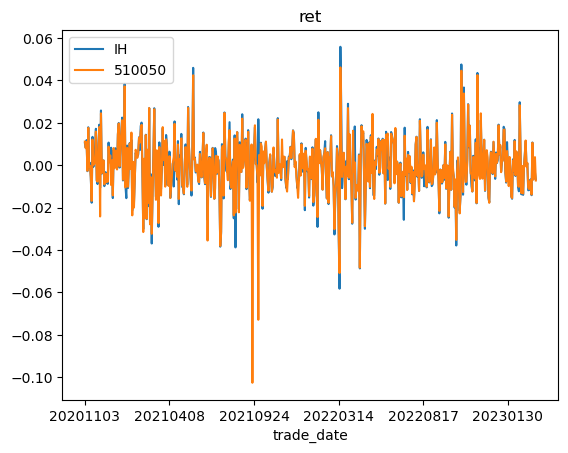

In [110]:
l = pd.merge(fut_returns,etf_returns,left_index=True, right_index=True)
l.index = l.index.astype('str')
l.plot()
plt.title('ret')


In [111]:
etf_returns[etf_returns<-0.05].dropna().index

Int64Index([20210922, 20211008, 20220315], dtype='int64', name='trade_date')

In [58]:
returns = (stock_returns-stock_returns.mean())/stock_returns.std() # 标准化ret
val, vec = np.linalg.eig(returns.corr())    # 相关系数矩阵的特征值 特征向量
all_eigenvecs = vec[:, val.argsort()[::-1]][:,0] # 排好序的特征向量
out_fct = (stock_returns/stock_returns.std()).dot(np.array(all_eigenvecs))
out_fct.name = 'stock'
history = pd.merge(etf_returns,fut_returns,left_index=True, right_index=True)
history = pd.merge(history,out_fct,left_index=True, right_index=True)
from scipy.stats import spearmanr
corr, p = spearmanr(history, axis=0)
print('秩相关系数：')
print(pd.DataFrame(corr,index=['510050','IH','stock'],columns=['510050','IH','stock']))
print('相关系数：')
print(history.corr())

秩相关系数：
          510050        IH     stock
510050  1.000000  0.953801 -0.881979
IH      0.953801  1.000000 -0.865607
stock  -0.881979 -0.865607  1.000000
相关系数：
          510050        IH     stock
510050  1.000000  0.886133 -0.810855
IH      0.886133  1.000000 -0.886459
stock  -0.810855 -0.886459  1.000000


In [59]:
returns = (stock_returns-stock_returns.mean())/stock_returns.std() # 标准化ret
val, vec = np.linalg.eig(returns.corr())    # 相关系数矩阵的特征值 特征向量
all_eigenvecs = vec[:, val.argsort()[::-1]][:,0] # 排好序的特征向量
out_fct = (stock_returns).dot(np.array(all_eigenvecs))
out_fct.name = 'stock'
history = pd.merge(etf_returns,fut_returns,left_index=True, right_index=True)
history = pd.merge(history,out_fct,left_index=True, right_index=True)
from scipy.stats import spearmanr
corr, p = spearmanr(history, axis=0)
print('降维后没有除以标准差：')
print('秩相关系数：')
print(pd.DataFrame(corr,index=['510050','IH','stock'],columns=['510050','IH','stock']))
print('相关系数：')
print(history.corr())


降维后没有除以标准差：
秩相关系数：
          510050        IH     stock
510050  1.000000  0.953801 -0.906892
IH      0.953801  1.000000 -0.890031
stock  -0.906892 -0.890031  1.000000
相关系数：
          510050        IH     stock
510050  1.000000  0.886133 -0.834429
IH      0.886133  1.000000 -0.909090
stock  -0.834429 -0.909090  1.000000


In [94]:
returns = (stock_returns.iloc[252:504]-stock_returns.iloc[252:504].mean())/stock_returns.iloc[252:504].std() # 标准化ret
val, vec = np.linalg.eig(returns.corr())    # 相关系数矩阵的特征值 特征向量
eigenvecs = vec[:, val.argsort()[::-1]][:,0] 
fct = stock_returns.iloc[252:504].dot(np.array(eigenvecs))
fct.name = 'stock'
history = pd.merge(etf_returns,fut_returns,left_index=True, right_index=True)
history = pd.merge(history,out_fct,left_index=True, right_index=True)
from scipy.stats import spearmanr
corr, p = spearmanr(history, axis=0)
print('降维后没有除以标准差：')
print('秩相关系数：')
print(pd.DataFrame(corr,index=['510050','IH','stock'],columns=['510050','IH','stock']))
print('相关系数：')
print(history.corr())


降维后没有除以标准差：
秩相关系数：
          510050        IH     stock
510050  1.000000  0.931194  0.866110
IH      0.931194  1.000000  0.845222
stock   0.866110  0.845222  1.000000
相关系数：
          510050        IH     stock
510050  1.000000  0.798528  0.725168
IH      0.798528  1.000000  0.874200
stock   0.725168  0.874200  1.000000


In [90]:
train_loss = pd.DataFrame(np.zeros([252,3]), index=etf_returns.index[:252], columns=['510050','IH','stock'])
test_loss = pd.DataFrame(np.zeros([252,3]), index=etf_returns.index[252:504], columns=['510050','IH','stock'])
train_history = (history - history.mean()) / history.std() # history包括510050、IH，以及PCA降维后的日收益率

OLSmodels_510050 = {stock: sm.OLS(stock_returns.iloc[:252][stock], train_history['510050']).fit() for stock in stock_returns.columns} 
beta_510050 = pd.DataFrame({stock: model.params for stock, model in OLSmodels_510050.items()})
resids_510050 = pd.DataFrame({stock: model.resid for stock, model in OLSmodels_510050.items()})
train_loss['510050'] = resids_510050.apply(np.square).apply(np.sum,axis=1)

OLSmodels_IH = {stock: sm.OLS(stock_returns.iloc[:252][stock], train_history['IH']).fit() for stock in stock_returns.columns} 
beta_IH = pd.DataFrame({stock: model.params for stock, model in OLSmodels_IH.items()})
resids_IH = pd.DataFrame({stock: model.resid for stock, model in OLSmodels_IH.items()})
train_loss['IH'] = resids_IH.apply(np.square).apply(np.sum,axis=1)

OLSmodels_stock = {stock: sm.OLS(stock_returns.iloc[:252][stock], train_history['stock']).fit() for stock in stock_returns.columns} 
beta_stock = pd.DataFrame({stock: model.params for stock, model in OLSmodels_stock.items()})
resids_stock = pd.DataFrame({stock: model.resid for stock, model in OLSmodels_stock.items()})
train_loss['stock'] = resids_stock.apply(np.square).apply(np.sum,axis=1)

# test_loss
for i in range(252): # 接下来的252天
    cur_returns = stock_returns.iloc[252+i]
    out_resids_510050 = cur_returns - cur_returns.dot(np.array(eigenvecs)) * beta_510050
    test_loss.iloc[i]['510050'] = sum(i**2 for i in out_resids_510050.iloc[0])

    out_resids_IH = cur_returns - cur_returns.dot(np.array(eigenvecs)) * beta_IH
    test_loss.iloc[i]['IH'] = sum(i**2 for i in out_resids_IH.iloc[0])

    out_resids_stock = cur_returns - cur_returns.dot(np.array(eigenvecs)) * beta_stock
    test_loss.iloc[i]['stock'] = sum(i**2 for i in out_resids_stock.iloc[0])

In [34]:
# 观察第一主成分
from sklearn.decomposition import PCA
date = []
window_length = 252
weight = pd.DataFrame(columns=history_returns.columns, index=history_returns.index)
curr_IF_IH = pd.DataFrame(columns=['000016.SH','000300.SH'], index=history_returns.index)
history_fut = get_fut(start=start, end=end)
for cur_num in range(window_length, history_returns.shape[0]):
    date.append(history_returns.index[cur_num-1])
    fut = history_fut.iloc[cur_num-window_length:cur_num] # 指数数据
    original_returns = history_returns.iloc[cur_num-window_length:cur_num]
    returns = (original_returns - original_returns.mean()) / original_returns.std() # 标准化数据
    model = PCA().fit(returns)
    pca_eigenvecs = model.components_[0]
    if np.mean(pca_eigenvecs) < 0: pca_eigenvecs = [-i for i in pca_eigenvecs]
    weight.loc[date[-1]] = pca_eigenvecs
    curr_IF_IH.loc[date[-1]]['000016.SH'] = original_returns.dot(pca_eigenvecs).corr(fut['000016.SH'])
    curr_IF_IH.loc[date[-1]]['000300.SH'] = original_returns.dot(pca_eigenvecs).corr(fut['000300.SH'])
weight = weight.dropna()
curr_IF_IH = curr_IF_IH.dropna()


In [39]:
sorted_weight = weight.take(weight.astype('float64').describe().loc['mean'].argsort(),1)

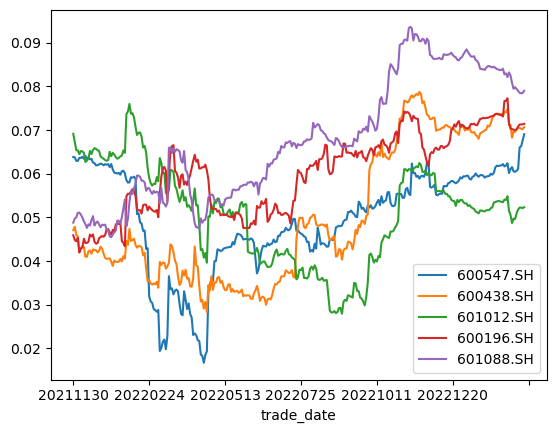

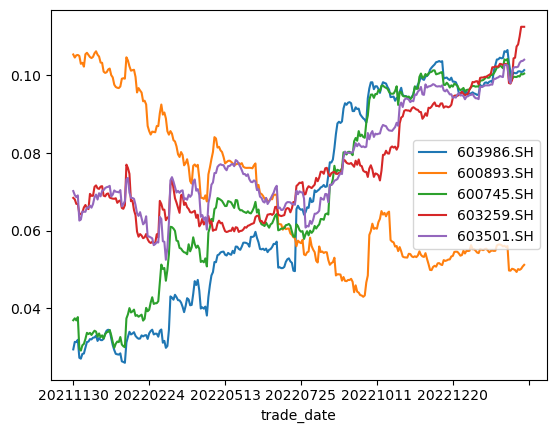

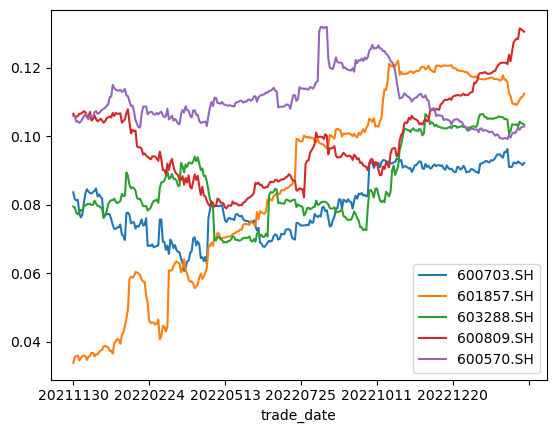

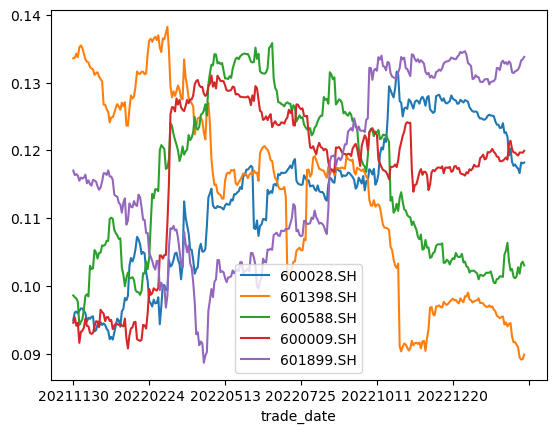

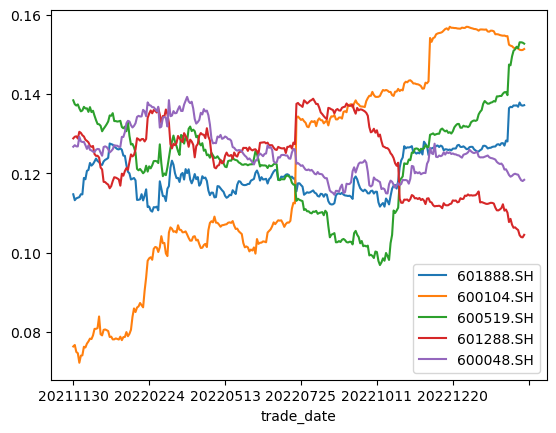

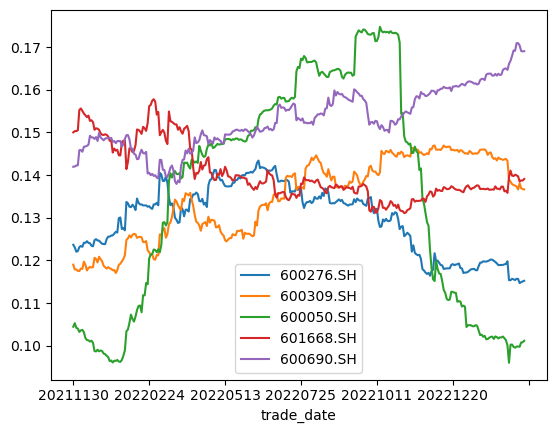

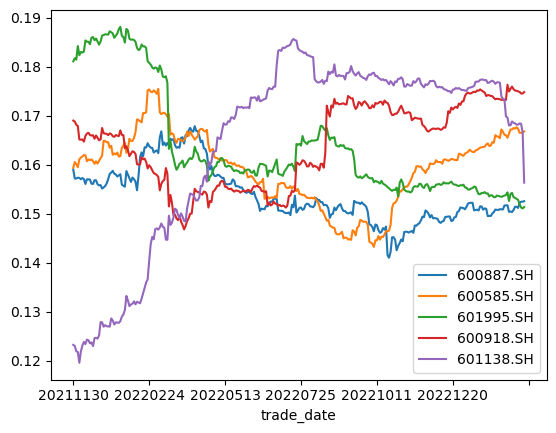

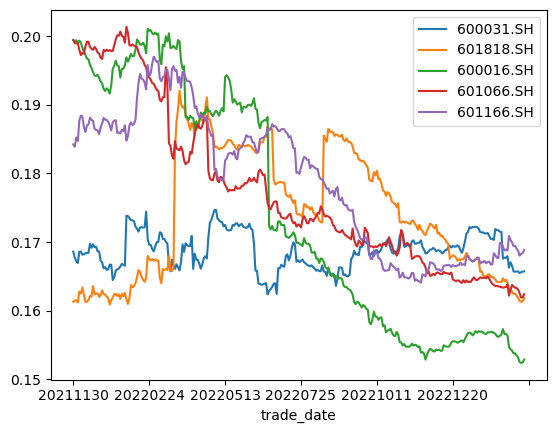

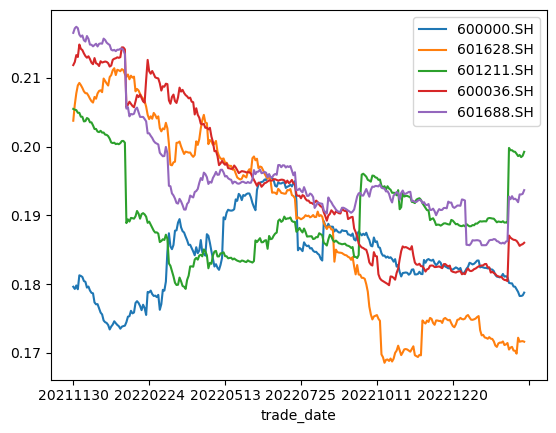

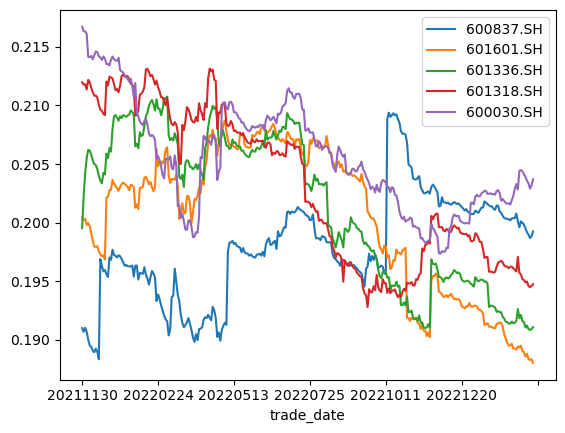

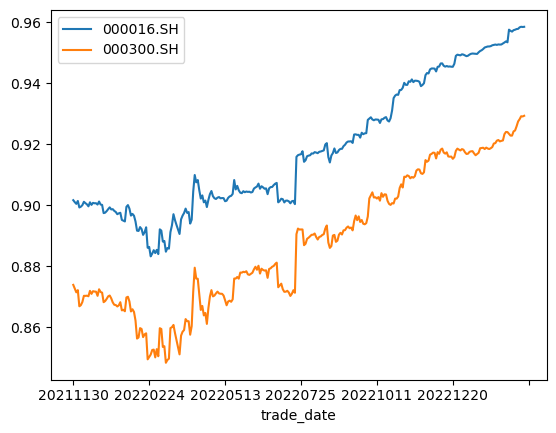

In [40]:
# weight可视化展示

sorted_weight[:][sorted_weight.columns[:5]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[5:10]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[10:15]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[15:20]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[20:25]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[25:30]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[30:35]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[35:40]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[40:45]].plot()
plt.show()
sorted_weight[:][sorted_weight.columns[45:50]].plot()
plt.show()
# IF IH相关系数展示
curr_IF_IH.plot()
plt.show()

In [26]:
for index in weight.index:
    for col in weight.columns:
        if weight[col].loc[index] < 0:
            print('index:{} col:{} weight:{}'.format(index,col,weight[col].loc[index]))
            


index:20220328 col:603659.SH weight:-0.0008797608813628241
index:20220328 col:603806.SH weight:-0.010007847897165389
index:20220328 col:002129.SZ weight:-0.0015185239402674385
index:20220328 col:002812.SZ weight:-0.017928710501419524
index:20220329 col:603659.SH weight:-0.0012507551087338291
index:20220329 col:603806.SH weight:-0.01008082336839162
index:20220329 col:002129.SZ weight:-0.0015039349465338508
index:20220329 col:002812.SZ weight:-0.017926372381816234
index:20220330 col:603659.SH weight:-0.0017704967963557685
index:20220330 col:603806.SH weight:-0.009924044710072414
index:20220330 col:002129.SZ weight:-0.0006312900195615261
index:20220330 col:002812.SZ weight:-0.017244915425582565
index:20220412 col:603659.SH weight:-0.0017538356382022983
index:20220412 col:603806.SH weight:-0.00971693242128975
index:20220412 col:002129.SZ weight:-0.0005692281656123254
index:20220412 col:002812.SZ weight:-0.017245278954194053
index:20220413 col:603659.SH weight:-0.0012504757846661034
index:2

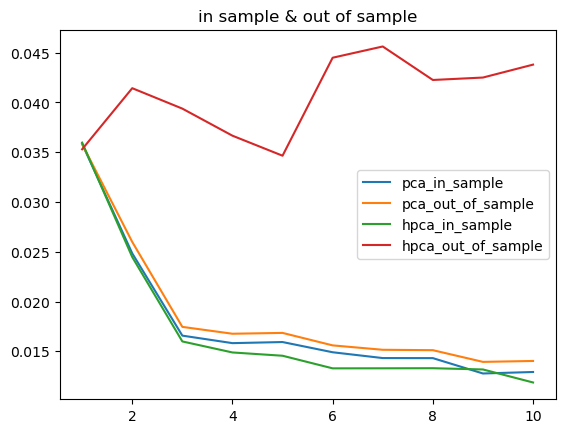

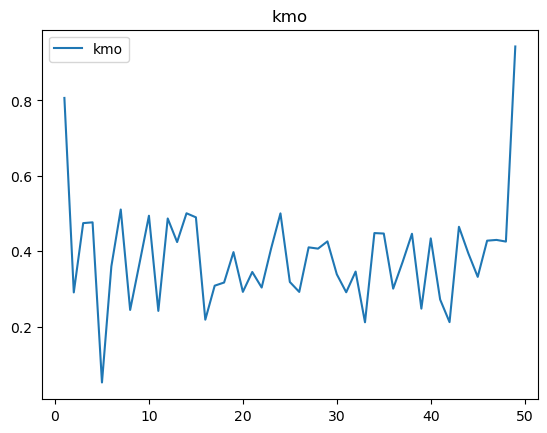

In [77]:
from factor_analyzer.factor_analyzer import calculate_kmo
loss = pd.DataFrame(index=np.arange(1,11), columns=['pca_in_sample','pca_out_of_sample','hpca_in_sample','hpca_out_of_sample'])
# kmo = pd.DataFrame(index=np.arange(1,11), columns=['kmo'])

original_returns = history_returns[i+5:i+5+window_length]
original_returns_5d_ago = history_returns[i:i+window_length]
returns = (original_returns - original_returns.mean())/original_returns.std()
returns_5d_ago = (original_returns_5d_ago - original_returns_5d_ago.mean())/original_returns_5d_ago.std()
P_model = PCA().fit(returns)
P_model_5d_ago = PCA().fit(returns_5d_ago)

sorted_correlations, HPCA_corr = correlations(returns, 19)
eigenvals_H, eigenvecs_H = np.linalg.eig(HPCA_corr)
idx_H = eigenvals_H.argsort()[::-1]   
sorted_correlations_5d_ago, HPCA_corr_5d_ago = correlations(returns_5d_ago, 19)
eigenvals_H_5d_ago, eigenvecs_H_5d_ago = np.linalg.eig(HPCA_corr_5d_ago)
idx_H_5d_ago = eigenvals_H_5d_ago.argsort()[::-1]

# kmo_returns = original_returns.copy()
for component in range(1,11):
    # pca_in_sample
    pca_eigenvecs = P_model.components_[:component]
    if np.mean(pca_eigenvecs) < 0: pca_eigenvecs = [-i for i in pca_eigenvecs] # 获取主成分
    fct = np.dot(original_returns/original_returns.std(),np.array(pca_eigenvecs).T) # 计算factor
    OLSmodels = {stock: sm.OLS(original_returns[stock], fct).fit() for stock in original_returns.columns} # ret与factor做回归
    resids = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels.items()})
    loss.loc[component]['pca_in_sample'] = sum(i**2 for i in resids.iloc[-1])

    # pca_out_of_sample
    pca_eigenvecs_5d_ago = P_model_5d_ago.components_[:component]
    if np.mean(pca_eigenvecs_5d_ago) < 0: pca_eigenvecs_5d_ago = [-i for i in pca_eigenvecs_5d_ago] 
    fct_5d_ago = np.dot(original_returns_5d_ago/original_returns_5d_ago.std(),np.array(pca_eigenvecs_5d_ago).T)
    OLSmodels_5d_ago = {stock: sm.OLS(original_returns_5d_ago[stock], fct_5d_ago).fit() for stock in original_returns.columns} #!!!只改动了这一行代码 我觉得修改得没错 的确全要用5天前的数据
    beta = pd.DataFrame({stock: model_P.params for stock, model_P in OLSmodels_5d_ago.items()}) # 保存5天前的回归beta值
    resids_5d_ago = original_returns.iloc[-1] - (original_returns.iloc[-1]/original_returns_5d_ago.std()).dot(np.array(pca_eigenvecs_5d_ago).T).dot(beta)
    loss.loc[component]['pca_out_of_sample'] = sum(i**2 for i in resids_5d_ago)

    # hpca_in_sample
    hpca_eigenvecs = eigenvecs_H[:, idx_H][:, :component] 
    if np.mean(hpca_eigenvecs) < 0: hpca_eigenvecs = [-i for i in hpca_eigenvecs]
    fct_H = np.dot(original_returns[HPCA_corr.columns]/original_returns[HPCA_corr.columns].std(),np.array(hpca_eigenvecs))
    OLSmodels_H = {stock: sm.OLS(original_returns[stock], fct_H).fit() for stock in original_returns.columns}
    resids_H = pd.DataFrame({stock: model_H.resid for stock, model_H in OLSmodels_H.items()})
    loss.loc[component]['hpca_in_sample'] = sum(i**2 for i in resids_H.iloc[-1])

    # hpca_out_of_sample
    hpca_eigenvecs_5d_ago = eigenvecs_H_5d_ago[:, idx_H_5d_ago][:, :component]
    if np.mean(hpca_eigenvecs_5d_ago) < 0: hpca_eigenvecs_5d_ago = [-i for i in hpca_eigenvecs_5d_ago] 
    fct_H_5d_ago = np.dot(original_returns_5d_ago[HPCA_corr.columns]/original_returns_5d_ago[HPCA_corr.columns].std(),np.array(hpca_eigenvecs_5d_ago))
    OLSmodels_H_5d_ago = {stock: sm.OLS(original_returns_5d_ago[stock], fct_H_5d_ago).fit() for stock in original_returns.columns}
    beta_H = pd.DataFrame({stock: model_H.params for stock, model_H in OLSmodels_H_5d_ago.items()})
    resids_H_5d_ago = original_returns.iloc[-1] - (original_returns.iloc[-1]/original_returns_5d_ago.std()).dot(np.array(hpca_eigenvecs_5d_ago)).dot(beta_H)
    loss.loc[component]['hpca_out_of_sample'] = sum(i**2 for i in resids_H_5d_ago)

loss.plot()
plt.title('in sample & out of sample')
plt.show()
kmo.plot()
plt.title('kmo')
plt.show()

In [31]:
start = '20201103'
end = '20230306'
history_returns = get_returns(start, end)
window_length = 252

loss = pd.DataFrame(np.zeros([10,4]), index=np.arange(1,11), columns=['pca_in_sample','pca_out_of_sample','hpca_in_sample','hpca_out_of_sample'])
explainedvar = pd.DataFrame(np.zeros([10,4]), index=np.arange(1,11), columns=['pca_in_sample','pca_out_of_sample','hpca_in_sample','hpca_out_of_sample'])
for i in range(21): # 迭代21天
    original_returns = history_returns[i+5:i+5+window_length] 
    original_returns_5d_ago = history_returns[i:i+window_length]
    returns = (original_returns - original_returns.mean())/original_returns.std()
    returns_5d_ago = (original_returns_5d_ago - original_returns_5d_ago.mean())/original_returns_5d_ago.std()
    P_model = PCA().fit(returns)
    P_model_5d_ago = PCA().fit(returns_5d_ago)
    explainedvar['pca_in_sample'] += pd.Series(P_model.explained_variance_ratio_[:10], index=np.arange(1,11))
    explainedvar['pca_out_of_sample'] += pd.Series(P_model_5d_ago.explained_variance_ratio_[:10], index=np.arange(1,11))

    sorted_correlations, HPCA_corr = correlations(returns, 19)
    eigenvals_H, eigenvecs_H = np.linalg.eig(HPCA_corr)
    idx_H = eigenvals_H.argsort()[::-1]   
    sorted_correlations_5d_ago, HPCA_corr_5d_ago = correlations(returns_5d_ago, 19)
    eigenvals_H_5d_ago, eigenvecs_H_5d_ago = np.linalg.eig(HPCA_corr_5d_ago)
    idx_H_5d_ago = eigenvals_H_5d_ago.argsort()[::-1]
    explainedvar['hpca_in_sample'] += pd.Series((eigenvals_H[idx_H]/eigenvals_H[idx_H].sum())[:10], index=np.arange(1,11))
    explainedvar['hpca_out_of_sample'] += pd.Series((eigenvals_H_5d_ago[idx_H]/eigenvals_H_5d_ago[idx_H].sum())[:10], index=np.arange(1,11))

    for component in range(1,11): # 迭代前k个component
        # pca_in_sample
        pca_eigenvecs = P_model.components_[:component]
        if np.mean(pca_eigenvecs) < 0: pca_eigenvecs = [-i for i in pca_eigenvecs] # 获取主成分
        fct = np.dot(original_returns/original_returns.std(),np.array(pca_eigenvecs).T) # 计算factor
        OLSmodels = {stock: sm.OLS(original_returns[stock], fct).fit() for stock in original_returns.columns} # ret与factor做回归
        resids = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels.items()})
        loss.loc[component]['pca_in_sample'] += sum(i**2 for i in resids.iloc[-1])

        # pca_out_of_sample
        pca_eigenvecs_5d_ago = P_model_5d_ago.components_[:component]
        if np.mean(pca_eigenvecs_5d_ago) < 0: pca_eigenvecs_5d_ago = [-i for i in pca_eigenvecs_5d_ago] 
        fct_5d_ago = np.dot(original_returns_5d_ago/original_returns_5d_ago.std(),np.array(pca_eigenvecs_5d_ago).T)
        OLSmodels_5d_ago = {stock: sm.OLS(original_returns_5d_ago[stock], fct_5d_ago).fit() for stock in original_returns.columns}
        beta = pd.DataFrame({stock: model_P.params for stock, model_P in OLSmodels_5d_ago.items()}) # 保存5天前的回归beta值
        resids_5d_ago = original_returns.iloc[-1] - (original_returns.iloc[-1]/original_returns_5d_ago.std()).dot(np.array(pca_eigenvecs_5d_ago).T).dot(beta)
        loss.loc[component]['pca_out_of_sample'] += sum(i**2 for i in resids_5d_ago)
        
        # hpca_in_sample
        hpca_eigenvecs = eigenvecs_H[:, idx_H][:, :component] 
        if np.mean(hpca_eigenvecs) < 0: hpca_eigenvecs = [-i for i in hpca_eigenvecs]
        fct_H = np.dot(original_returns[HPCA_corr.columns]/original_returns[HPCA_corr.columns].std(),np.array(hpca_eigenvecs))
        OLSmodels_H = {stock: sm.OLS(original_returns[stock], fct_H).fit() for stock in original_returns.columns}
        resids_H = pd.DataFrame({stock: model_H.resid for stock, model_H in OLSmodels_H.items()})
        loss.loc[component]['hpca_in_sample'] += sum(i**2 for i in resids_H.iloc[-1])

        # hpca_out_of_sample
        hpca_eigenvecs_5d_ago = eigenvecs_H_5d_ago[:, idx_H_5d_ago][:, :component]
        if np.mean(hpca_eigenvecs_5d_ago) < 0: hpca_eigenvecs_5d_ago = [-i for i in hpca_eigenvecs_5d_ago] 
        fct_H_5d_ago = np.dot(original_returns_5d_ago[HPCA_corr.columns]/original_returns_5d_ago[HPCA_corr.columns].std(),np.array(hpca_eigenvecs_5d_ago))
        OLSmodels_H_5d_ago = {stock: sm.OLS(original_returns_5d_ago[stock], fct_H_5d_ago).fit() for stock in original_returns.columns}
        beta_H = pd.DataFrame({stock: model_H.params for stock, model_H in OLSmodels_H_5d_ago.items()})
        resids_H_5d_ago = original_returns.iloc[-1] - (original_returns.iloc[-1]/original_returns_5d_ago.std()).dot(np.array(hpca_eigenvecs_5d_ago)).dot(beta_H)
        loss.loc[component]['hpca_out_of_sample'] += sum(i**2 for i in resids_H_5d_ago)
loss = loss / 10
explainedvar = explainedvar / 10
loss.plot()
plt.ylabel('sum of loss squares')
plt.xlabel('n_component')
plt.show()
explainedvar.plot()
plt.ylabel('explainedVariance')
plt.xlabel('n_component')
plt.show()


KeyboardInterrupt: 

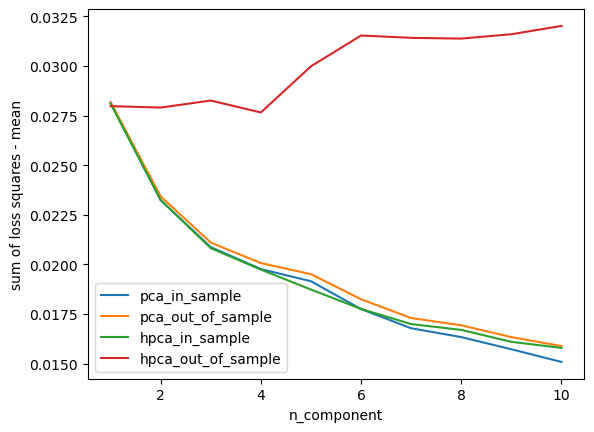

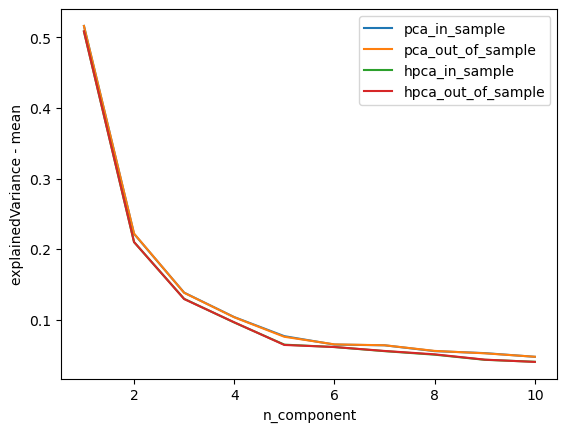

In [105]:
loss.plot()
plt.ylabel('sum of loss squares - mean')
plt.xlabel('n_component')
plt.show()
explainedvar.plot()
plt.ylabel('explainedVariance - mean')
plt.xlabel('n_component')
plt.show()

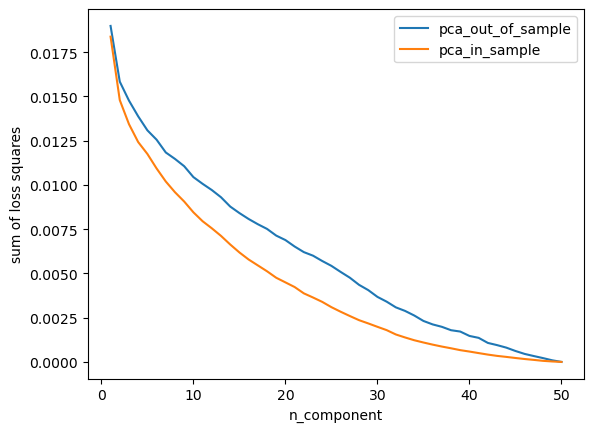

In [141]:
loss = pd.DataFrame(np.zeros([50,2]),index=np.arange(1,51), columns=['pca_out_of_sample','pca_in_sample'])
original_returns = history_returns.iloc[:252]
returns = (original_returns-original_returns.mean())/original_returns.std()
val, vec = np.linalg.eig(returns.corr())
all_eigenvecs = vec[:, val.argsort()[::-1]] # 排好序的特征向量

for n_component in range(1,51):
    # out_fct和beta为outofsample测试要用的参数 还包括original_returns.std()
    eigenvecs = all_eigenvecs[:, :n_component]
    out_fct = np.dot(original_returns/original_returns.std(), np.array(eigenvecs)) # 保存factor
    OLSmodels = {stock: sm.OLS(original_returns[stock], out_fct).fit() for stock in returns.columns} # ret与factor做回归
    beta = pd.DataFrame({stock: model.params for stock, model in OLSmodels.items()}) # 保存回归系数
    for i in range(252): # 迭代接下来的252天
        cur_returns = history_returns.iloc[i:252+i]
        # pca_out_sample
        out_resids = cur_returns.iloc[-1] - (cur_returns.iloc[-1]/original_returns.std()).dot(np.array(eigenvecs)).dot(beta)
        loss.loc[n_component]['pca_out_of_sample'] += sum(i**2 for i in out_resids)
        # pca_in_sample
        P_model = PCA().fit((cur_returns-cur_returns.mean())/cur_returns.std())
        pca_eigenvecs = P_model.components_[:n_component]
        fct = np.dot(cur_returns/cur_returns.std(),np.array(pca_eigenvecs).T)
        OLSmodels = {stock: sm.OLS(cur_returns[stock], fct).fit() for stock in cur_returns.columns} 
        resids = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels.items()})
        loss.loc[n_component]['pca_in_sample'] += sum(i**2 for i in resids.iloc[-1])
loss = loss / 252
loss.plot()
plt.xlabel('n_component')
plt.ylabel('sum of loss squares')
plt.show()

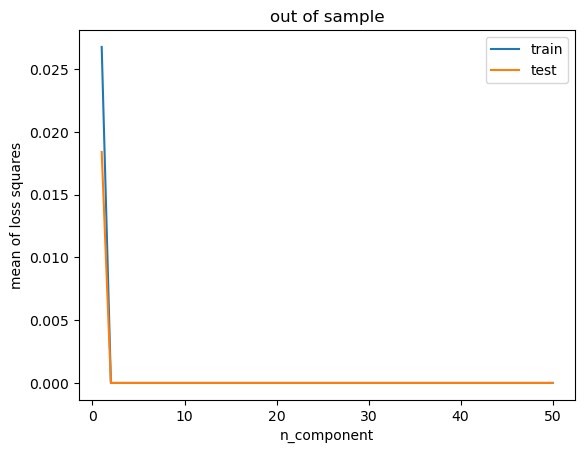

In [32]:
loss = pd.DataFrame(np.zeros([50,2]),index=np.arange(1,51), columns=['train','test'])
original_returns = stock_returns.iloc[:252] # 第0~251天数据
returns = (original_returns-original_returns.mean())/original_returns.std() # 标准化ret
val, vec = np.linalg.eig(returns.corr())    # 相关系数矩阵的特征值 特征向量
all_eigenvecs = vec[:, val.argsort()[::-1]] # 排好序的特征向量

n_component = 1

# outofsample测试要用的数据包括original_returns.std(),eigenvecs,beta
eigenvecs = all_eigenvecs[:, :n_component]
out_fct = (original_returns/original_returns.std()).dot(np.array(eigenvecs)) # 保存factor
OLSmodels = {stock: sm.OLS(original_returns[stock], out_fct).fit() for stock in returns.columns} # ret与factor做回归
beta = pd.DataFrame({stock: model.params for stock, model in OLSmodels.items()}) # 保存回归系数beta 
# train_loss     
resids = pd.DataFrame({stock: model.resid for stock, model in OLSmodels.items()})
loss.loc[n_component]['train'] = resids.apply(np.square).apply(np.sum,axis=1).sum()
# test_loss
for i in range(252): # 接下来的252天
    cur_returns = history_returns.iloc[252+i]
    out_resids = cur_returns - (cur_returns/original_returns.std()).dot(np.array(eigenvecs)).dot(beta)
    loss.loc[n_component]['test'] += sum(i**2 for i in out_resids)
loss = loss / 252 # 对残差平方和求均值
loss.plot()
plt.title('out of sample')
plt.xlabel('n_component')
plt.ylabel('mean of loss squares')
plt.show()

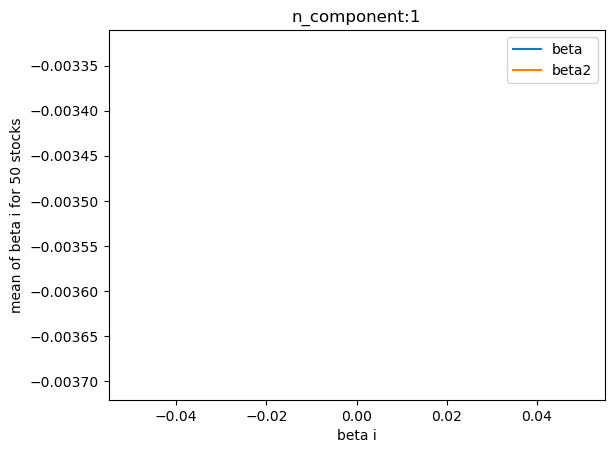

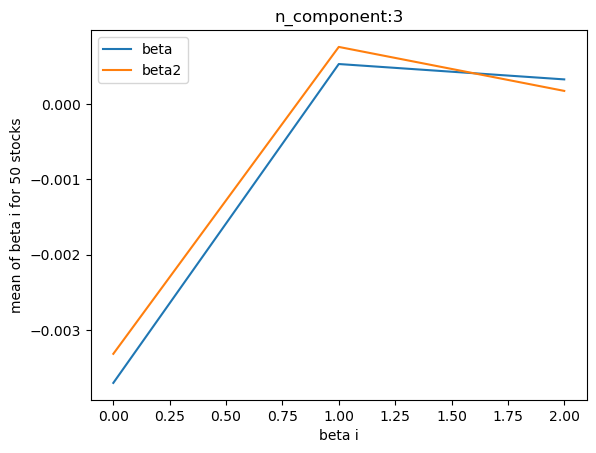

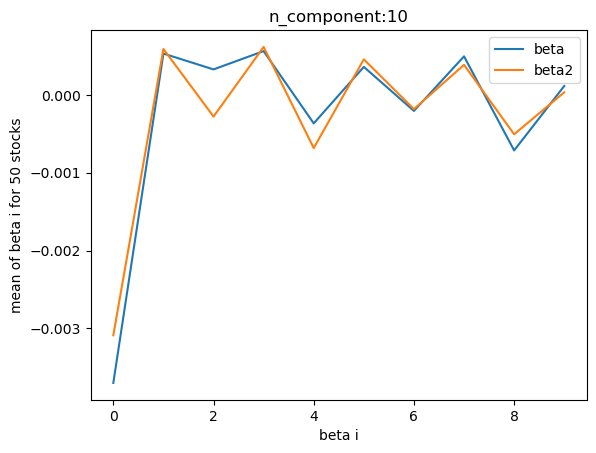

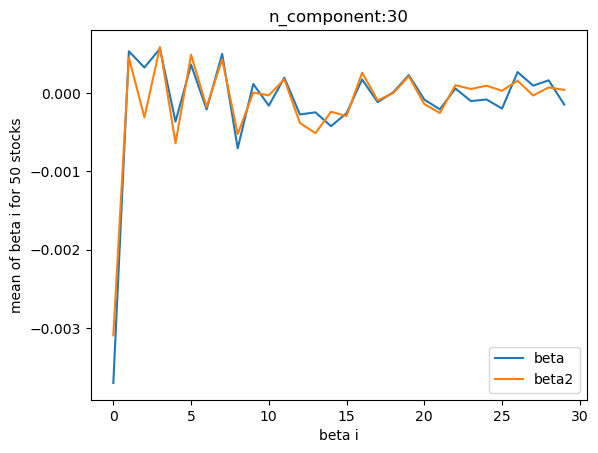

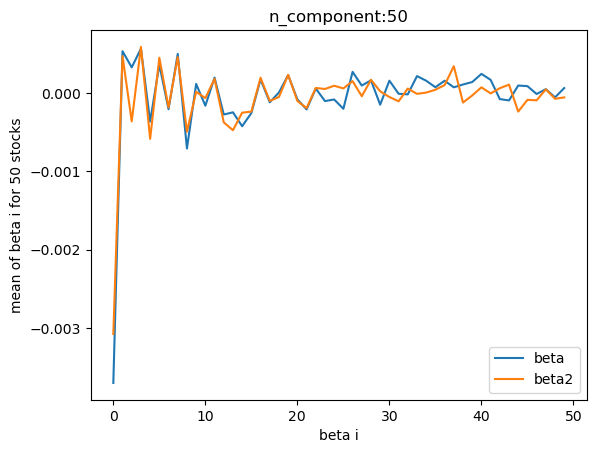

In [209]:
loss = pd.DataFrame(np.zeros([50,2]),index=np.arange(1,51), columns=['train','test'])
original_returns_1 = history_returns.iloc[:252] # 第0~251天数据
original_returns_2 = history_returns.iloc[252:252+252]
returns_1 = (original_returns_1-original_returns_1.mean())/original_returns_1.std() # 标准化ret
returns_2 = (original_returns_2-original_returns_2.mean())/original_returns_2.std() # 标准化ret
val, vec = np.linalg.eig(returns_1.corr())    # 相关系数矩阵的特征值 特征向量
all_eigenvecs = vec[:, val.argsort()[::-1]] # 排好序的特征向量
val2, vec2 = np.linalg.eig(returns_2.corr())    # 相关系数矩阵的特征值 特征向量
all_eigenvecs2 = vec[:, val2.argsort()[::-1]] # 排好序的特征向量

for n_component in [1,3,10,30,50]:
    eigenvecs = all_eigenvecs[:, :n_component]
    out_fct = (original_returns_1/original_returns_1.std()).dot(np.array(eigenvecs)) # 保存factor
    OLSmodels = {stock: sm.OLS(original_returns_1[stock], out_fct).fit() for stock in returns_1.columns} # ret与factor做回归
    beta = pd.DataFrame({stock: model.params for stock, model in OLSmodels.items()}) # 保存回归系数beta   
    eigenvecs2 = all_eigenvecs2[:, :n_component]
    out_fct2 = (original_returns_2/original_returns_2.std()).dot(np.array(eigenvecs2)) # 保存factor
    OLSmodels2 = {stock: sm.OLS(original_returns_2[stock], out_fct2).fit() for stock in returns_2.columns} # ret与factor做回归
    beta2 = pd.DataFrame({stock: model.params for stock, model in OLSmodels2.items()}) # 保存回归系数beta 
    df = pd.DataFrame(index=np.arange(n_component))
    df['beta'],df['beta2'] = beta.mean(axis=1),beta2.mean(axis=1)
    df.plot()
    plt.xlabel('beta i')
    plt.ylabel('mean of beta i for 50 stocks')
    plt.title('n_component:{}'.format(n_component))
    plt.show()

In [156]:
# 回测一下
loss = pd.DataFrame(np.zeros([50,2]),index=np.arange(1,51), columns=['train','test'])
original_returns = history_returns.iloc[:252] # 第0~251天数据
returns = (original_returns-original_returns.mean())/original_returns.std() # 标准化ret
val, vec = np.linalg.eig(returns.corr())    # 相关系数矩阵的特征值 特征向量
all_eigenvecs = vec[:, val.argsort()[::-1]] # 排好序的特征向量

for n_component in range(1,51):
    # out_fct和beta为outofsample测试要用的参数 还包括original_returns.std()
    eigenvecs = all_eigenvecs[:, :n_component]
    out_fct = (original_returns/original_returns.std()).dot(np.array(eigenvecs)) # 保存factor
    OLSmodels = {stock: sm.OLS(original_returns[stock], out_fct).fit() for stock in returns.columns} # ret与factor做回归
    beta = pd.DataFrame({stock: model.params for stock, model in OLSmodels.items()}) # 保存回归系数beta 
    # train_loss     
    resids = pd.DataFrame({stock: model.resid for stock, model in OLSmodels.items()})
    loss.loc[n_component]['train'] = resids.apply(np.square).apply(np.sum,axis=1).sum()
    # test_loss
    for i in range(252): # 接下来的252天
        cur_returns = history_returns.iloc[252+i]
        out_resids = cur_returns - (cur_returns/original_returns.std()).dot(np.array(eigenvecs)).dot(beta)
        loss.loc[n_component]['test'] += sum(i**2 for i in out_resids)
loss = loss / 252 # 对残差平方和求均值
loss.plot()
plt.title('out of sample')
plt.xlabel('n_component')
plt.ylabel('mean of loss squares')
plt.show()

,train,test
46,2.165376e-04,4.637033e-04
47,1.452908e-04,3.422746e-04
48,9.923075e-05,2.669523e-04
49,3.996772e-05,1.065850e-04
50,4.460245e-31,5.163754e-31


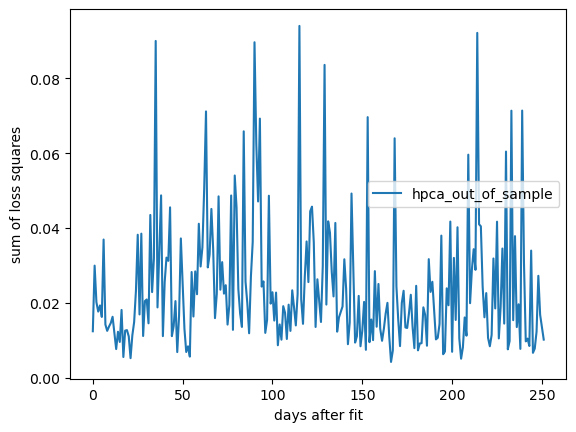

In [114]:
original_returns = history_returns.iloc[:252]
returns = (original_returns-original_returns.mean())/original_returns.std()
sorted_correlations, HPCA_corr = correlations(returns,19)
val, vec = np.linalg.eig(HPCA_corr)
eigenvecs = vec[:, val.argsort()[::-1]][:,:10]
fct = np.dot(original_returns[HPCA_corr.columns]/original_returns[HPCA_corr.columns].std(),np.array(eigenvecs)) # 计算factor
OLSmodels = {stock: sm.OLS(original_returns[stock], fct).fit() for stock in original_returns.columns} # ret与factor做回归
beta = pd.DataFrame({stock: model.params for stock, model in OLSmodels.items()})

loss = pd.DataFrame(index=np.arange(252), columns=['hpca_out_of_sample'])

for i in range(252):
    cur_returns = history_returns.iloc[251+i]
    out_resids = cur_returns - (cur_returns/original_returns.std()).dot(np.array(eigenvecs)).dot(beta)
    loss.loc[i]['hpca_out_of_sample'] = sum(i**2 for i in out_resids)
    
loss.plot()
plt.xlabel('days after fit')
plt.ylabel('sum of loss squares')
plt.show()

In [ ]:
start = '20201103'
end = '20230306'
history_returns = get_returns(start, end)
window_length = 252

loss = pd.DataFrame(np.zeros([10,2]), index=np.arange(1,11), columns=['pca_in_sample','pca_out_of_sample'])

for i in range(21): # 迭代21天
    original_returns = history_returns[i+5:i+5+window_length] 
    original_returns_5d_ago = history_returns[i:i+window_length]
    returns = (original_returns - original_returns.mean())/original_returns.std()
    returns_5d_ago = (original_returns_5d_ago - original_returns_5d_ago.mean())/original_returns_5d_ago.std()
    P_model = PCA().fit(returns)
    P_model_5d_ago = PCA().fit(returns_5d_ago)



    for component in range(1,11): # 迭代前k个component
        # pca_in_sample
        pca_eigenvecs = P_model.components_[:component]
        if np.mean(pca_eigenvecs) < 0: pca_eigenvecs = [-i for i in pca_eigenvecs] # 获取主成分
        fct = np.dot(original_returns/original_returns.std(),np.array(pca_eigenvecs).T) # 计算factor
        OLSmodels = {stock: sm.OLS(original_returns[stock], fct).fit() for stock in original_returns.columns} # ret与factor做回归
        resids = pd.DataFrame({stock: model_P.resid for stock, model_P in OLSmodels.items()})
        loss.loc[component]['pca_in_sample'] += sum(i**2 for i in resids.iloc[-1])

        # pca_out_of_sample
        pca_eigenvecs_5d_ago = P_model_5d_ago.components_[:component]
        if np.mean(pca_eigenvecs_5d_ago) < 0: pca_eigenvecs_5d_ago = [-i for i in pca_eigenvecs_5d_ago] 
        fct_5d_ago = np.dot(original_returns_5d_ago/original_returns_5d_ago.std(),np.array(pca_eigenvecs_5d_ago).T)
        OLSmodels_5d_ago = {stock: sm.OLS(original_returns_5d_ago[stock], fct_5d_ago).fit() for stock in original_returns.columns}
        beta = pd.DataFrame({stock: model_P.params for stock, model_P in OLSmodels_5d_ago.items()}) # 保存5天前的回归beta值
        resids_5d_ago = original_returns.iloc[-1] - (original_returns.iloc[-1]/original_returns_5d_ago.std()).dot(np.array(pca_eigenvecs_5d_ago).T).dot(beta)
        loss.loc[component]['pca_out_of_sample'] += sum(i**2 for i in resids_5d_ago)

In [148]:
resids.mean()

600000.SH    2.759553e-18
600009.SH   -2.337058e-18
600016.SH    1.216286e-18
600028.SH    2.934015e-18
600030.SH    5.902878e-19
600031.SH   -6.699681e-18
600036.SH   -1.321694e-18
600048.SH    2.282848e-18
600050.SH    2.209707e-18
600104.SH   -1.927471e-18
600196.SH   -2.049658e-18
600276.SH   -6.283210e-18
600309.SH   -7.866489e-18
600438.SH    5.713573e-19
600519.SH   -4.566556e-18
600547.SH    1.686537e-18
600570.SH   -3.059859e-18
600585.SH   -1.375904e-18
600588.SH   -4.274854e-18
600690.SH   -4.194830e-18
600703.SH    1.738165e-19
600745.SH    1.497232e-18
600809.SH   -1.105542e-17
600837.SH    1.045481e-18
600887.SH   -7.513693e-18
600893.SH   -4.808351e-18
600918.SH   -9.060832e-18
601012.SH   -7.869931e-18
601066.SH    3.174303e-18
601088.SH    5.490710e-18
601138.SH    5.593106e-21
601166.SH    3.743079e-19
601211.SH    2.663179e-19
601288.SH    1.430545e-20
601318.SH    2.244126e-18
601336.SH    2.836135e-18
601398.SH    2.272952e-18
601601.SH    4.825345e-18
601628.SH   